## Ring-hydroxylating Dioxygenases

In [104]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re
from prince import CA, MCA
import matplotlib.cm as cm
from Bio.SeqUtils import seq3
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pyclustering.cluster.optics import optics
from pyclustering.cluster.optics import ordering_analyser
from sklearn.cluster import OPTICS
import networkx as nx
from itertools import combinations
from sklearn.manifold import MDS

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lucas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
headers, sequences = [], []
for record in SeqIO.parse('alignment.fasta', "fasta").records:
    headers.append(record.id)
    sequences.append(record.seq)
raw = np.array(sequences)
print(raw.shape)

(9381, 1225)


In [3]:
# Create a data frame from array containing raw data and then clean it up

df = pd.DataFrame(raw)

df.replace(
    ['-', *[chr(i) for i in range(ord('a'), ord('z')+1)]],
    np.nan,
    inplace=True
)

threshold = .9
min_rows = int(threshold * df.shape[0])

# Remove columns with NaN values above the threshold
df.dropna(thresh=min_rows, axis=1, inplace=True)
min_cols = int(threshold * df.shape[1])

print(min_rows, min_cols)

# Remove rows with NaN values above the threshold
df.dropna(thresh=min_cols, axis=0, inplace=True)

row_idx, col_idx = df.index, df.columns

print(df.info)

8442 36
<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      A   L   Y   C   E   G   F   H   V   H  ...   T   Y   V   Y   D   E   E  \
1      K   L   Y   M   D   P   Y   H   L   H  ...   Y   F   G   Y   E   D   D   
2      K   L   T   Y   E   N   Y   H   I   H  ...   L   Y   W   K   G   E   E   
3      K   V   F   C   D   G   Y   H   A   H  ...   Y   F   L   E   G   S   E   
4      K   V   V   N   E   C   Y   H   N   H  ...   W   F   V   A   D   A   Q   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
9373   K   T   F   I   E   D   Y   H   F   H  ...   F   F   Y   P   E   E   E   
9376   K   M   Y   L   D   T   V   H   T   H  ...   S   F   R   A   A   G   D   
9377   K   L   T   M   E   C   Y   H   N   H  ...   W   L   V   H   R   D   Q   
9378   K   L   V   V   D   F   Y   H   V   H  ...   V   F   V   D   N   S   Q   
9380   K   L   T   M   E   C   Y   H   N   H  ...   W   C   V   H   R

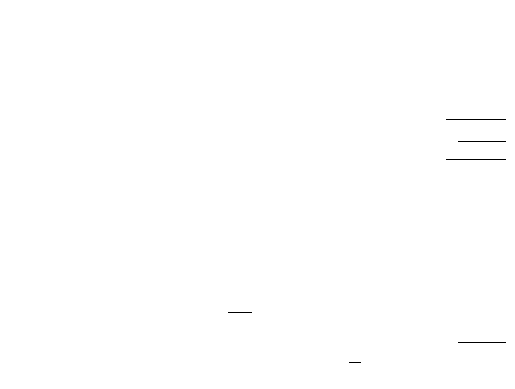

In [4]:
# Plot the heatmap
sns.heatmap(df.isna().astype(int), cmap='binary', xticklabels=False, yticklabels=False, cbar=False)

# Show the plot
plt.show()

In [5]:
# Join the dataframes based on the 'ID' column
if len(df.columns) == len(col_idx):
    if (df.columns == col_idx).all():
        df = pd.merge(
            pd.merge(
                pd.read_csv('data.tsv', delimiter='\t'),
                pd.DataFrame(
                    {
                        'Entry':[headers[idx].split('/')[0].split('_')[0] for idx in df.index],
                        'Index':list(df.index)
                    }
                ),
                on='Entry'
            ),
            df,
            left_on='Index',
            right_index=True,
            how='inner'
        ).copy()
print(df.info)

<bound method DataFrame.info of            Entry        Entry Name   
0     A0A401KD97  A0A401KD97_ASPAW  \
1     A0A024HID4  A0A024HID4_PSEKB   
2     A0A0B7G8U8  A0A0B7G8U8_KLEVA   
3     A0A0D1ZK14  A0A0D1ZK14_9EURO   
4     A0A0F3KB91  A0A0F3KB91_9NEIS   
...          ...               ...   
7221      X8BD72      X8BD72_MYCAV   
7222      X8C3G7      X8C3G7_MYCXE   
7223      X8C7K7      X8C7K7_MYCXE   
7224      X8F6Q2      X8F6Q2_MYCUL   
7225      Y0KGF3      Y0KGF3_9PROT   

                                          Protein names   
0     Bifunctional lycopene cyclase/phytoene synthas...  \
1     Carnitine monooxygenase oxygenase subunit (EC ...   
2     Carnitine monooxygenase oxygenase subunit (EC ...   
3     Choline monooxygenase, chloroplastic (EC 1.14....   
4     Carnitine monooxygenase oxygenase subunit (EC ...   
...                                                 ...   
7221                              Rieske domain protein   
7222                              Riesk

In [6]:
df['Protein names'].value_counts(normalize=True)

Protein names
Aromatic ring-hydroxylating dioxygenase subunit alpha                                                                                0.123997
(2Fe-2S)-binding protein                                                                                                             0.089676
Choline monooxygenase, chloroplastic (EC 1.14.15.7)                                                                                  0.069056
Rieske (2Fe-2S) protein                                                                                                              0.061998
Rieske domain-containing protein                                                                                                     0.059369
                                                                                                                                       ...   
Putative Choline monooxygenase (EC 1.14.15.7)                                                                                        0

In [7]:
# Extract the substrate and enzyme names using regular expressions
matches = df['Protein names'].str.extract(r'(.+?) ([\w\-,]+ase)', flags=re.IGNORECASE)

# String normalization pipeline
df['Substrate'] = matches[0]\
    .fillna('')\
    .apply(lambda x: '/'.join(re.findall(r'\b(\w+(?:ene|ine|ate|yl))\b', x, flags=re.IGNORECASE)))\
    .apply(lambda x: x.lower())

df['Enzyme'] = matches[1]\
    .fillna('')\
    .apply(lambda x: x.split('-')[-1] if '-' in x else x) \
    .apply(lambda x: x.lower())

df = df.copy()

df[['Substrate', 'Enzyme']].value_counts(normalize=True)

Substrate                               Enzyme        
                                                          0.467063
                                        dioxygenase       0.185580
choline                                 monooxygenase     0.090922
phenylpropionate                        dioxygenase       0.072654
benzoate                                dioxygenase       0.043316
anthranilate                            dioxygenase       0.027539
salicylate                              hydroxylase       0.017437
                                        oxygenase         0.015361
biphenyl                                dioxygenase       0.010379
benzene                                 dioxygenase       0.008165
naphthalene                             dioxygenase       0.007750
carnitine                               monooxygenase     0.007750
cumate                                  dioxygenase       0.006643
halobenzoate                            dioxygenase       0.006228
benzoat

In [8]:
df['Enzyme'].value_counts(normalize=True)

Enzyme
                  0.467063
dioxygenase       0.389842
monooxygenase     0.100055
hydroxylase       0.017991
oxygenase         0.015776
demethylase       0.003045
oxidoreductase    0.001384
reductase         0.001384
cyclase           0.000830
synthase          0.000692
diooxygenase      0.000415
decarboxylase     0.000415
dyoxygenase       0.000415
ligase            0.000138
dehydrogenase     0.000138
helicase          0.000138
protease          0.000138
dioxyenase        0.000138
Name: proportion, dtype: float64

In [9]:
df['Substrate'].value_counts(normalize=True)

Substrate
                                          0.672571
choline                                   0.090922
phenylpropionate                          0.072654
benzoate                                  0.043454
anthranilate                              0.027539
salicylate                                0.017714
biphenyl                                  0.010379
benzene                                   0.008165
naphthalene                               0.007750
carnitine                                 0.007750
cumate                                    0.006643
halobenzoate                              0.006228
benzoate/toluate                          0.005397
terephthalate                             0.003737
phenylpropionate/cinnamate                0.003183
glycine/betaine                           0.003045
phthalate                                 0.002629
toluate                                   0.001384
methanesulfonate                          0.001384
phenoxybenzoate      

In [10]:
df['Label'] = df['Substrate'].str.cat(df['Enzyme'], sep=' ').str.strip()
df = df.copy()
df['Label'].value_counts(normalize=True)

Label
                                                        0.467063
dioxygenase                                             0.185580
choline monooxygenase                                   0.090922
phenylpropionate dioxygenase                            0.072654
benzoate dioxygenase                                    0.043316
anthranilate dioxygenase                                0.027539
salicylate hydroxylase                                  0.017437
oxygenase                                               0.015361
biphenyl dioxygenase                                    0.010379
benzene dioxygenase                                     0.008165
carnitine monooxygenase                                 0.007750
naphthalene dioxygenase                                 0.007750
cumate dioxygenase                                      0.006643
halobenzoate dioxygenase                                0.006228
benzoate/toluate dioxygenase                            0.005397
terephthalate dioxy

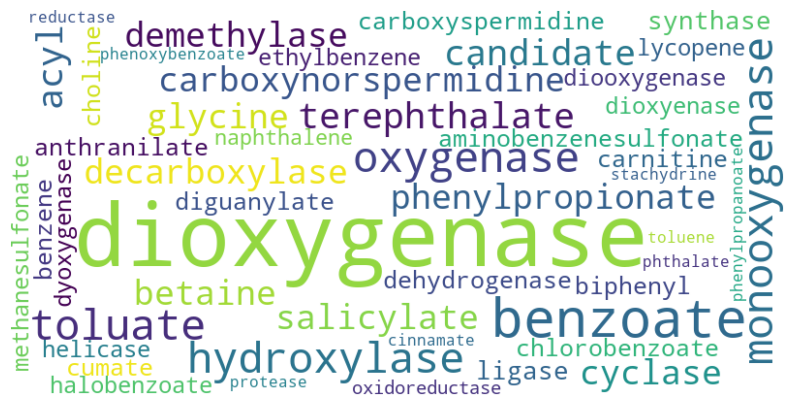

In [11]:
# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(
    WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(
        ' '.join(
            sorted(
                set([string for string in df.Label.values.tolist() if len(string) > 0])
            )
        )
    ),
    interpolation='bilinear'
)
plt.axis('off')
plt.show()

In [12]:
data = df[col_idx].drop_duplicates().fillna('-').copy()
data.info

<bound method DataFrame.info of      182 185 186 187 200 204 205 206 216 217  ... 838 841 845 848 851 853 982   
0      K   L   L   I   E   C   Y   H   S   H  ...   V   Y   R   H   R   D   E  \
1      K   S   I   V   E   C   Y   H   A   H  ...   I   Y   F   L   N   K   E   
2      K   N   I   V   E   C   Y   H   A   H  ...   I   Y   F   T   N   E   E   
3      K   T   L   A   E   C   Y   H   A   H  ...   V   Y   R   H   V   D   E   
4      K   I   I   V   E   C   Y   H   A   H  ...   I   Y   F   R   N   K   E   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
7218   K   M   V   V   D   G   Y   H   T   H  ...   A   V   L   I   P   G   D   
7221   K   L   Y   M   E   F   Y   H   L   H  ...   L   Y   F   P   A   P   Q   
7223   K   M   V   V   D   G   Y   H   T   H  ...   A   V   L   M   P   G   D   
7224   K   V   L   V   E   G   Y   H   T   H  ...   S   M   V   T   P   M   -   
7225   K   T   F   I   E   D   Y   H   F   H  ...   F   Y   Y   P   E   D   E

In [13]:
# Perform MCA
mca = MCA()
mca.fit(data)

# Access the results
coordinates = mca.transform(data)

# mca.plot(
#     data,
#     x_component=0,
#     y_component=1
# )

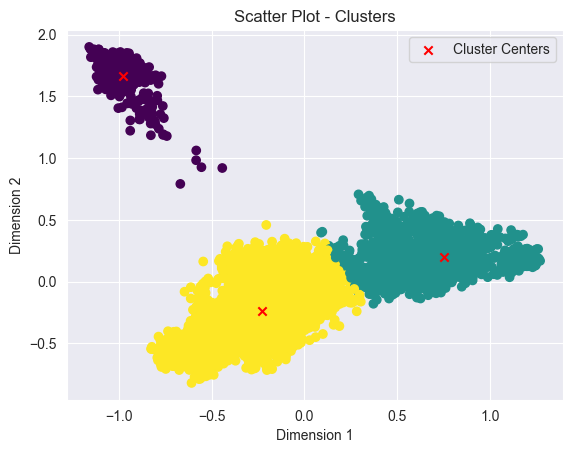

In [62]:
# Assuming 'coordinates' is the result of MCA

# Convert the coordinates to a NumPy array
coordinates = np.array(coordinates)

# Define a range of potential number of clusters to evaluate
min_clusters = 3
max_clusters = 10

# Perform clustering for different number of clusters and compute silhouette scores
silhouette_scores = []
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, n_init=10)  # Set n_init explicitly
    kmeans.fit(coordinates)
    labels = kmeans.labels_
    score = silhouette_score(coordinates, labels)
    silhouette_scores.append(score)

# Find the best number of clusters based on the highest silhouette score
best_num_clusters = np.argmax(silhouette_scores) + min_clusters

# Perform clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_num_clusters, n_init=10)  # Set n_init explicitly
kmeans.fit(coordinates)
kmeans_cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Plot the scatter plot colored by clusters
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=kmeans_cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', label='Cluster Centers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot - Clusters')
plt.legend()
plt.show()

In [15]:
X = data
y = pd.get_dummies(kmeans_cluster_labels).astype(int) if len(
    set(kmeans_cluster_labels)
) > 2 else kmeans_cluster_labels

# Perform one-hot encoding on the categorical features
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# Get the column names for the encoded features
encoded_feature_names = []
for i, column in enumerate(X.columns):
    categories = encoder.categories_[i]
    for category in categories:
        feature_name = f'{column}_{category}'
        encoded_feature_names.append(feature_name)

# Convert X_encoded to DataFrame
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded, columns=encoded_feature_names)

# Create and train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_encoded_df, y)

# Feature selection
feature_selector = SelectFromModel(rf, threshold='median')
X_selected = feature_selector.fit_transform(X_encoded_df, y)

selected_feature_indices = feature_selector.get_support(indices=True)
selected_features = X_encoded_df.columns[selected_feature_indices]

selected_features

Index(['185_A', '185_F', '185_I', '185_L', '185_M', '185_N', '185_S', '185_T',
       '185_V', '186_A',
       ...
       '987_C', '987_D', '987_E', '987_G', '987_H', '987_P', '987_R', '987_S',
       '987_V', '987_W'],
      dtype='object', length=364)

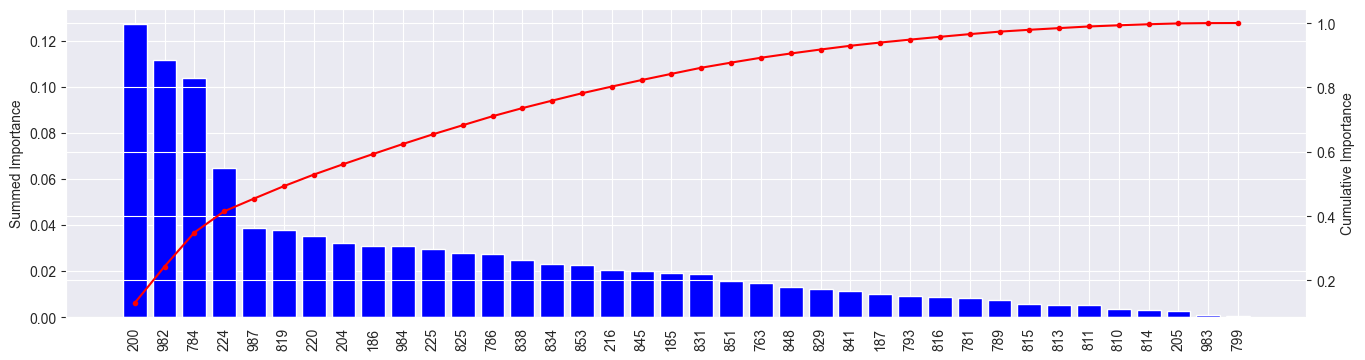

In [16]:
# Calculate feature importances for original columns
sorted_importance = pd.DataFrame(
    {
        'Residues': selected_features,
        'Importance': rf.feature_importances_[selected_feature_indices],
        'Columns': map(lambda x: int(x.split('_')[0]), selected_features)
    }
)[['Columns', 'Importance']].groupby('Columns').sum()['Importance'].sort_values(ascending=False)
sorted_features = sorted_importance.index

fig, ax1 = plt.subplots(figsize=(16, 4))

# Bar chart of percentage importance
xvalues = range(len(sorted_features))
ax1.bar(xvalues, sorted_importance, color='b')
ax1.set_ylabel('Summed Importance')
ax1.tick_params(axis='y')

# Line chart of cumulative percentage importance
ax2 = ax1.twinx()
ax2.plot(xvalues, np.cumsum(sorted_importance) / np.sum(sorted_importance), color='r', marker='.')
ax2.set_ylabel('Cumulative Importance')
ax2.tick_params(axis='y')

# Rotate x-axis labels
plt.xticks(xvalues, sorted_features)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

plt.show()


In [17]:
# Calculate cumulative sum of importance
cumulative_importance = np.cumsum(sorted_importance) / np.sum(sorted_importance)

# Find the index where cumulative importance exceeds or equals 0.9
index = np.where(cumulative_importance >= 0.9)[0][0]

# Get the values from sorted_features up to the index
selected_columns = sorted_features[:index+1].values

# Print the retrieved values
print(selected_columns)

[200 982 784 224 987 819 220 204 186 984 225 825 786 838 834 853 216 845
 185 831 851 763 848]


In [18]:
def henikoff(data):
    data_array = data.to_numpy()  # Convert DataFrame to NumPy array
    size, length = data_array.shape
    weights = []
    for seq_index in range(size):
        row = data_array[seq_index, :]
        unique_vals, counts = np.unique(row, return_counts=True)
        k = len(unique_vals)
        matrix_row = 1. / (k * counts)
        weights.append(np.sum(matrix_row) / length)
    return pd.Series(weights, index=data.index)

In [19]:
weights = henikoff(data[selected_columns])
print(weights)

0       0.031494
1       0.033816
2       0.034873
3       0.031573
4       0.034058
          ...   
7218    0.030100
7221    0.028684
7223    0.031215
7224    0.035300
7225    0.031884
Length: 6219, dtype: float64


In [20]:
data[selected_columns]

,200,982,784,224,987,819,220,204,186,984,...,838,834,853,216,845,185,831,851,763,848
0,E,E,Q,L,D,K,P,C,L,R,...,V,E,D,S,R,L,N,R,C,H
1,E,E,I,S,R,L,P,C,I,L,...,I,D,K,A,F,S,Y,N,T,L
2,E,E,T,G,R,L,P,C,I,L,...,I,D,E,A,F,N,Y,N,M,T
3,E,E,M,D,H,S,P,C,L,K,...,V,E,D,A,R,T,Y,V,Y,H
4,E,E,I,G,R,L,P,C,I,L,...,I,D,K,A,F,I,Y,N,T,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7218,D,D,M,S,E,I,A,G,V,G,...,A,T,G,T,L,M,T,P,N,I
7221,E,Q,Y,N,N,V,A,F,Y,A,...,L,T,P,L,F,L,G,A,L,P
7223,D,D,M,S,E,I,A,G,V,G,...,A,T,G,T,L,M,T,P,N,M
7224,E,-,V,D,-,A,K,G,L,-,...,S,Y,M,T,V,V,I,P,A,T


In [21]:
selected_residues = [x for x in selected_features if int(x.split('_')[0]) in selected_columns]
df_res = mca.column_coordinates(data[selected_columns]).loc[selected_residues]
df_res.info

<bound method DataFrame.info of               0         1
185_A -0.055684 -0.235623
185_F  0.995013  0.235622
185_I  0.365919 -0.061756
185_L -0.005798 -0.292504
185_M  1.200993  0.143502
...         ...       ...
987_P  0.011059 -0.177430
987_R -0.543098 -0.607884
987_S -0.249590 -0.654941
987_V  0.226763 -0.124473
987_W -0.085646 -0.164205

[247 rows x 2 columns]>

In [22]:
# Create an empty graph
G = nx.Graph()
for idx in df_res.index:
    col, aa = idx.split('_')
    col = int(col)
    rows = data[selected_columns].index[data[selected_columns][col] == aa].tolist()
    # Filter and sum values based on valid indices
    p = weights.iloc[[i for i in rows if i < len(weights)]].sum()
    # Add a node with attributes
    G.add_node(
        f'{seq3(aa)}{col}',
        idx=idx,
        aa=aa,
        col=col,
        coord=(
            df_res.loc[idx,0],
            df_res.loc[idx,1]
        ),
        rows=rows,
        p=p
    )
G.nodes

NodeView(('Ala185', 'Phe185', 'Ile185', 'Leu185', 'Met185', 'Asn185', 'Ser185', 'Thr185', 'Val185', 'Ala186', 'Phe186', 'Gly186', 'His186', 'Ile186', 'Leu186', 'Met186', 'Asn186', 'Pro186', 'Gln186', 'Val186', 'Trp186', 'Tyr186', 'Ala200', 'Asp200', 'Glu200', 'Gly200', 'Ser200', 'Ala204', 'Cys204', 'Asp204', 'Gly204', 'Met204', 'Asn204', 'Pro204', 'Ser204', 'Thr204', 'Ala216', 'Phe216', 'Ile216', 'Leu216', 'Asn216', 'Ser216', 'Thr216', 'Val216', 'Tyr216', 'Ala220', 'Asp220', 'Glu220', 'Gly220', 'Lys220', 'Leu220', 'Pro220', 'Gln220', 'Arg220', 'Ser220', 'Thr220', 'Trp220', 'Ala224', 'Asp224', 'Glu224', 'Phe224', 'Gly224', 'Lys224', 'Asn224', 'Gln224', 'Arg224', 'Ser224', 'Thr224', 'Trp224', 'Ala225', 'Phe225', 'His225', 'Ile225', 'Leu225', 'Gln225', 'Ser225', 'Thr225', 'Val225', 'Tyr225', 'Ala763', 'Asp763', 'Phe763', 'Gly763', 'Ile763', 'Leu763', 'Met763', 'Asn763', 'Gln763', 'Ser763', 'Thr763', 'Val763', 'Trp763', 'Ala784', 'Glu784', 'Phe784', 'His784', 'Ile784', 'Lys784', 'Leu784', 

In [23]:
for u in G.nodes:
    print(u, G.nodes[u]['idx'])

Ala185 185_A
Phe185 185_F
Ile185 185_I
Leu185 185_L
Met185 185_M
Asn185 185_N
Ser185 185_S
Thr185 185_T
Val185 185_V
Ala186 186_A
Phe186 186_F
Gly186 186_G
His186 186_H
Ile186 186_I
Leu186 186_L
Met186 186_M
Asn186 186_N
Pro186 186_P
Gln186 186_Q
Val186 186_V
Trp186 186_W
Tyr186 186_Y
Ala200 200_A
Asp200 200_D
Glu200 200_E
Gly200 200_G
Ser200 200_S
Ala204 204_A
Cys204 204_C
Asp204 204_D
Gly204 204_G
Met204 204_M
Asn204 204_N
Pro204 204_P
Ser204 204_S
Thr204 204_T
Ala216 216_A
Phe216 216_F
Ile216 216_I
Leu216 216_L
Asn216 216_N
Ser216 216_S
Thr216 216_T
Val216 216_V
Tyr216 216_Y
Ala220 220_A
Asp220 220_D
Glu220 220_E
Gly220 220_G
Lys220 220_K
Leu220 220_L
Pro220 220_P
Gln220 220_Q
Arg220 220_R
Ser220 220_S
Thr220 220_T
Trp220 220_W
Ala224 224_A
Asp224 224_D
Glu224 224_E
Phe224 224_F
Gly224 224_G
Lys224 224_K
Asn224 224_N
Gln224 224_Q
Arg224 224_R
Ser224 224_S
Thr224 224_T
Trp224 224_W
Ala225 225_A
Phe225 225_F
His225 225_H
Ile225 225_I
Leu225 225_L
Gln225 225_Q
Ser225 225_S
Thr225 225_T

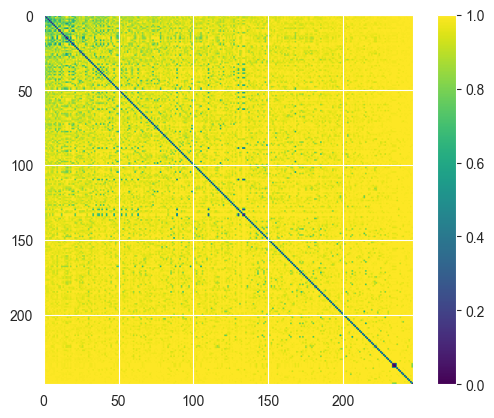

In [77]:
# Generate pairwise combinations
pairwise_comparisons = list(combinations(G.nodes, 2))

# Add edges to graph based on pairwise calculation of Jaccard's dissimilarity (1 - similarity)
for u, v in pairwise_comparisons:
    asymmetric_distance = set(G.nodes[u]['rows']) ^ set(G.nodes[v]['rows'])
    union = set(G.nodes[u]['rows']) | set(G.nodes[v]['rows'])
    weight = float(
        weights.iloc[[i for i in list(asymmetric_distance) if i < len(weights)]].sum()
    ) / float(
        weights.iloc[[i for i in list(union) if i < len(weights)]].sum()
    ) if G.nodes[u]['col'] != G.nodes[v]['col'] else 1.
    G.add_edge(
        u,
        v,
        weight = weight
    )

# Generate distance matrix
N = sorted(G.nodes(), key=lambda x: G.nodes[x]['p'], reverse=True)
D = nx.to_numpy_array(G, nodelist=N)

# Plot the distance matrix
fig, ax = plt.subplots()
im = ax.imshow(D, cmap='viridis')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

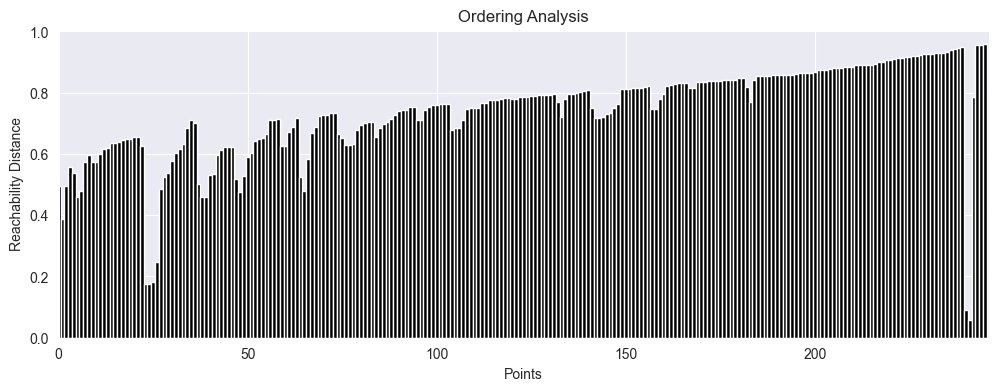

In [140]:
# OPTICS density clustering algorithm
optics_instance = optics(
    D, eps=np.inf, minpts=2, amount_clusters=10, data_type='distance_matrix'
)
optics_instance.process()
clusters = optics_instance.get_clusters()

# Get cluster labels for each point
cluster_labels = np.zeros(len(N), dtype=int)
for cluster_id, cluster in enumerate(clusters):
    cluster_labels[cluster] = cluster_id

# Plot the ordering analysis
ordering = ordering_analyser(optics_instance.get_ordering())
ordering = ordering.cluster_ordering

plt.figure(figsize=(12, 4))  # Set the figsize to (width, height)
plt.bar(range(0, len(ordering)), ordering[0:len(ordering)], width=1., color='black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.title('Ordering Analysis')
plt.show()

In [141]:
# Find the unique values and their counts
unique_values, counts = np.unique(cluster_labels, return_counts=True)

# Calculate the proportion of unique values
proportions = counts / len(cluster_labels)

# Print the unique values and their proportions
for value, count, proportion in zip(unique_values, counts, proportions):
    print(value, count, proportion)

0 228 0.9230769230769231
1 9 0.03643724696356275
2 3 0.012145748987854251
3 2 0.008097165991902834
4 1 0.004048582995951417
5 1 0.004048582995951417
6 3 0.012145748987854251


In [128]:
# Assuming D is the distance matrix

# Perform MDS to obtain the actual points
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
points = mds.fit_transform(D)

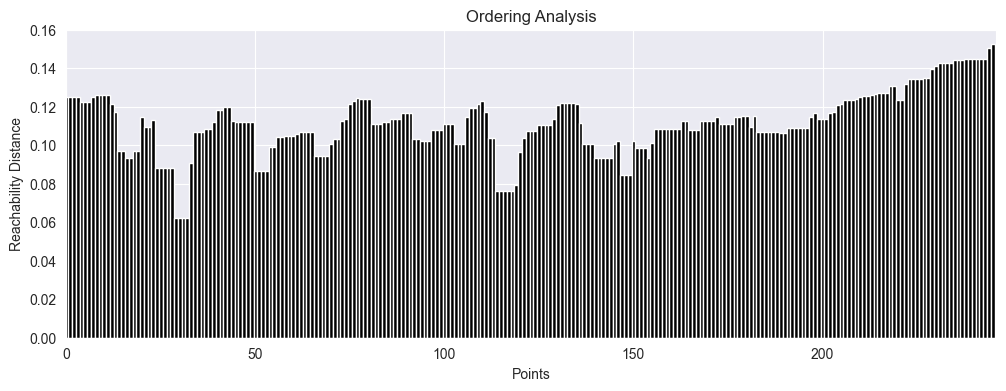

In [130]:
# OPTICS density clustering algorithm
optics_instance = optics(
    [(x, y) for x, y in points], eps=np.inf, minpts=5, amount_clusters=10
)
optics_instance.process()
clusters = optics_instance.get_clusters()

# Get cluster labels for each point
cluster_labels = np.zeros(len(N), dtype=int)
for cluster_id, cluster in enumerate(clusters):
    cluster_labels[cluster] = cluster_id

# Plot the ordering analysis
ordering = ordering_analyser(optics_instance.get_ordering())
ordering = ordering.cluster_ordering

plt.figure(figsize=(12, 4))  # Set the figsize to (width, height)
plt.bar(range(0, len(ordering)), ordering[0:len(ordering)], width=1., color='black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.title('Ordering Analysis')
plt.show()

In [131]:
# Find the unique values and their counts
unique_values, counts = np.unique(cluster_labels, return_counts=True)

# Calculate the proportion of unique values
proportions = counts / len(cluster_labels)

# Print the unique values and their proportions
for value, count, proportion in zip(unique_values, counts, proportions):
    print(value, count, proportion)

0 105 0.4251012145748988
1 21 0.08502024291497975
2 28 0.11336032388663968
3 69 0.2793522267206478
4 24 0.09716599190283401


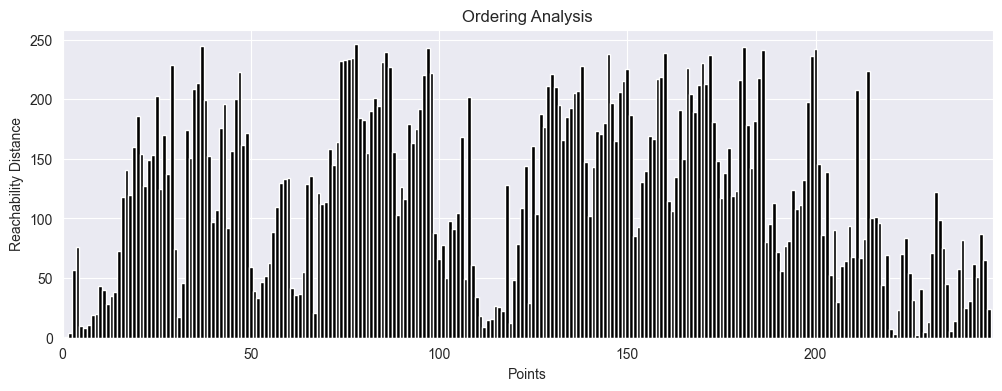

In [132]:
# Apply OPTICS on the points
clust = OPTICS()
clust.fit(points)

# Retrieve cluster labels and ordering information
cluster_labels = clust.labels_
ordering = clust.ordering_

# Plot the ordering analysis
plt.figure(figsize=(12, 4))
plt.bar(range(len(ordering)), ordering, width=1., color='black')
plt.xlim([0, len(ordering)])
plt.xlabel('Points')
plt.ylabel('Reachability Distance')
plt.title('Ordering Analysis')
plt.show()

In [133]:
# Find the unique values and their counts
unique_values, counts = np.unique(cluster_labels, return_counts=True)

# Calculate the proportion of unique values
proportions = counts / len(cluster_labels)

# Print the unique values and their proportions
for value, count, proportion in zip(unique_values, counts, proportions):
    print(value, count, proportion)

-1 158 0.6396761133603239
0 5 0.020242914979757085
1 9 0.03643724696356275
2 10 0.04048582995951417
3 11 0.044534412955465584
4 8 0.032388663967611336
5 9 0.03643724696356275
6 7 0.02834008097165992
7 6 0.024291497975708502
8 5 0.020242914979757085
9 5 0.020242914979757085
10 8 0.032388663967611336
11 6 0.024291497975708502


In [134]:
# # Create a scatter plot colored by cluster
# plt.scatter(coordinates[:, 0], coordinates[:, 1], c=cluster_labels)
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.title(f'OPTICS Clustering with {best_num_clusters} clusters')
# plt.show()

In [135]:
# plt.figure(figsize=(12, 4))  # Set the figsize to (width, height)
#
# # Density based clustering by OPTICS through distance (dissimilarity) matrix
# optics_instance = optics(D, eps=1., minpts=3, amount_clusters=None, data_type='distance_matrix')
# optics_instance.process()
#
# clusters = sorted(
#     optics_instance.get_clusters(),
#     key=lambda x: np.mean(
#         [G.nodes[N[i]]['p'] for i in x]
#     ), reverse=True
# )
#
# ordering = ordering_analyser(optics_instance.get_ordering())
# ordering = ordering.cluster_ordering
#
# # Reachability plot
# plt.bar(range(0, len(ordering)), ordering[0:len(ordering)], width=1., color='black')
# plt.xlim([0, len(ordering)])
# plt.xlabel('Points')
# plt.ylabel('Reachability Distance')
# plt.show()

In [136]:
len(clusters)

5

In [137]:
clusters

[[8,
  74,
  28,
  38,
  35,
  73,
  40,
  118,
  141,
  160,
  19,
  20,
  11,
  10,
  43,
  120,
  170,
  186,
  154,
  127,
  203,
  153,
  149,
  125,
  137,
  229,
  174,
  209,
  214,
  151,
  245,
  223,
  199,
  107,
  46],
 [15,
  16,
  18,
  22,
  34,
  27,
  61,
  50,
  49,
  78,
  105,
  98,
  168,
  88,
  91,
  202,
  66,
  175,
  128,
  144,
  163],
 [33,
  39,
  52,
  63,
  47,
  89,
  134,
  130,
  110,
  133,
  59,
  42,
  55,
  37,
  36,
  129,
  136,
  162,
  172,
  157,
  92,
  200,
  176,
  152,
  196,
  97,
  121,
  208],
 [85,
  102,
  93,
  147,
  185,
  166,
  205,
  207,
  193,
  195,
  143,
  173,
  171,
  180,
  238,
  225,
  206,
  215,
  197,
  165,
  187,
  228,
  210,
  211,
  177,
  188,
  161,
  221,
  131,
  217,
  169,
  167,
  219,
  115,
  135,
  106,
  124,
  140,
  191,
  150,
  237,
  226,
  239,
  242,
  198,
  132,
  108,
  111,
  204,
  212,
  230,
  189,
  213,
  244,
  181,
  159,
  148,
  138,
  117,
  178,
  182,
  216,
  142,
  123,
  11